In [1]:
!pip install yfinance --upgrade --no-cache-dir

# PART-1 전통적인 금융 이론

## 거래자산과 차익거래 예제
- 2-기간 금융 모델에서 유러피안 콜 옵션의 초기 가격을 계산하는 방식
- 옵션의 미래 가치를 계산하고, 이를 바탕으로 옵션의 현재 가치를 추정
- C0는 이 모델에서 행사가 K=14.5인 유러피안 콜 옵션의 시점 0에서의 가격
- 주식 및 채권에 대한 비중을 구한 후, 이를 시점 0의 주식 및 채권 가격과 곱하여 옵션의 현재 가치를 계산하는 방식
- 차익거래 가격결정 이론(APT : Arbitrage Pricing Theory)

In [2]:
import numpy as np

# 시점 0에서 주식과 채권의 가격
S0 = 10  # 현재 주식 가격
B0 = 10  # 현재 채권(무위험 자산) 가격

# 시점 1에서 주식과 채권의 가격 배열 (각각 두 가지 경우)
S1 = np.array((20, 5))  # 미래의 주식 가격 (상승 시 20, 하락 시 5)
B1 = np.array((11, 11))  # 미래의 채권 가격 (두 경우 모두 11)

# 시점 0에서 주식과 채권의 가격 벡터
M0 = np.array((S0, B0))

# 시점 1에서 주식과 채권의 가격 행렬 (전치하여 두 가지 경우를 행으로)
M1 = np.array((S1, B1)).T

# 옵션의 행사가
K = 14.5

# 시점 1에서의 콜 옵션 종가 (max(주식 가격 - 행사가, 0))
C1 = np.maximum(S1 - K, 0)

# 선형 방정식 M1 * phi = C1 을 풀어 주식과 채권의 비율(phi) 계산
phi = np.linalg.solve(M1, C1)

# 계산된 phi로부터 실제로 C1을 재구성할 수 있는지 확인
np.allclose(C1, np.dot(M1, phi))

# 시점 0에서 콜 옵션의 현재 가격 계산 (주식과 채권의 현재 가격과 phi의 내적)
C0 = np.dot(M0, phi)

# 결과 출력 (C0은 옵션의 현재 가격)
print(C0)


2.0


## 기대효용 이론 수치 예제
- 참조 : https://github.com/yhilpisch/aiif
- 기대효용함수
  + 리스크 회피형 베르누이 효용 함수
  + 사람들이 같은 기댓값을 가진 선택지 중에서도 리스크가 적은 선택지를 선호하는 성향을 반영
  + 안정적인 보상을 더 가치 있게 여긴다는 가정 반영
- 불확실성 하의 의사결정
- 리스크 회피
- 기대값 계산

In [3]:
# 리스크 회피 베르누이 효용함수
def u(x):
    return np.sqrt(x)

# 서로 다른 가중치를 가진 두 개의 포트폴리오
phi_A = np.array((0.75, 0.25))  # A 상태의 확률 분포
phi_D = np.array((0.25, 0.75))  # D 상태의 확률 분포

# 두 포트폴리오를 만드는 비용은 같음
np.dot(M0, phi_A) == np.dot(M0, phi_D)

# 한 포트폴리오의 페이오프
A1 = np.dot(M1, phi_A)

# 다른 포트폴리오의 페이오프
D1 = np.dot(M1, phi_D)

# 확률 측도
P = np.array((0.5, 0.5))

# 기대 효용 함수 정의
def EUT(x):
    return np.dot(P, u(x))

# 두 페이오프의 효용치
print(EUT(A1))

# 두 페이오프의 효용치
print(EUT(D1))

3.381292321692286
3.3611309730623735


- 전형적인 문제 : 고정 비용으로 양의 가중치를 가진 최적의 포트폴리오 찾기

In [4]:
from scipy.optimize import minimize

# 고정된 예산 w
w = 10  # 예산 제약 조건으로 포트폴리오가 가질 수 있는 자산 총합이 10으로 고정됨

# 함수에 넣을 제한 조건: 포트폴리오가 고정된 예산 w에 맞추어져야 함
cons = {'type': 'eq', 'fun': lambda phi: np.dot(M0, phi) - w}
# 제한 조건은 M0와 포트폴리오 벡터 phi의 내적이 예산 w와 같아야 함을 의미
# 'eq'는 방정식 형태의 제약 조건을 의미하며, 이 경우 np.dot(M0, phi) - w = 0이 되어야 함

# 포트폴리오에 대해 정의한 기대 효용 함수
def EUT_(phi):
    x = np.dot(M1, phi)  # 포트폴리오 phi에 따른 페이오프 x 계산
    return EUT(x)  # 계산된 페이오프에 대해 기대 효용을 반환

# 최적화 함수 minimize를 사용하여 기대 효용을 최대화하는 최적의 포트폴리오를 찾음
# 최적화 대상은 기대 효용을 최대화하는 포트폴리오 구성
opt = minimize(lambda phi: -EUT_(phi),  # maximize를 위해 -EUT를 minimize로 전환
               x0=phi_A,                # 초기값으로 phi_A (초기 포트폴리오)를 사용
               constraints=cons)        # 예산 제약 조건을 추가

# 최적 포트폴리오와 최적화 결과 출력
print(opt)

# 최적 포트폴리오에 대해 얻을 수 있는 기대 효용 출력
print(EUT_(opt['x']))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.385015999493397
       x: [ 6.112e-01  3.888e-01]
     nit: 4
     jac: [-1.692e+00 -1.693e+00]
    nfev: 12
    njev: 4
3.385015999493397


## 평균-분산 포트폴리오

In [5]:
import numpy as np

# 기대 수익률 함수
# rX: 수익률 벡터
# P: 확률 측도 (각 시나리오의 확률)
# np.dot(P, rX): P와 rX의 내적을 통해 가중 평균 기대 수익률을 계산
def mu(rX):
    return np.dot(P, rX)

# 시점 0에서 주식과 채권의 가격
S0 = 10  # 현재 주식 가격
B0 = 10  # 현재 채권(무위험 자산) 가격

# 시점 1에서 주식과 채권의 가격 배열 (각각 두 가지 경우)
S1 = np.array((20, 5))  # 미래의 주식 가격 (상승 시 20, 하락 시 5)
B1 = np.array((11, 11))  # 미래의 채권 가격 (두 경우 모두 11)

# 확률 측도 (각 시나리오의 확률)
P = np.array((0.5, 0.5))

# 시점 0에서 주식과 채권의 가격 벡터
M0 = np.array((S0, B0))

# 시점 1에서 주식과 채권의 가격 행렬 (전치하여 두 가지 경우를 행으로)
# S1과 B1이 행렬의 각 행에 위치하게 함
M1 = np.array((S1, B1)).T

# 위험 자산(주식)의 수익률 벡터
# 각 시나리오에서 주식의 수익률 계산
rS = S1 / S0 - 1

# 무위험 자산(채권)의 수익률 벡터
# 각 시나리오에서 채권의 수익률 계산
rB = B1 / B0 - 1

# 주식과 채권의 수익률 출력
print(rS, rB)

# 기대 수익률 출력
# mu(rS): 주식의 기대 수익률
# mu(rB): 채권의 기대 수익률
print(mu(rS), mu(rB))

# 수익률 행렬
# M1 (시점 1의 가격)에서 M0 (시점 0의 가격)을 나누고 1을 뺀 값을 계산
rM = M1 / M0 - 1

# 기대 수익률 벡터 출력
# mu(rM): 수익률 행렬에 대해 각각의 기대 수익률을 계산
print(mu(rM))

[ 1.  -0.5] [0.1 0.1]
0.25 0.10000000000000009
[0.25 0.1 ]


- 분산, 변동성, 공분산 행렬

In [6]:
# 분산 함수
# 수익률 벡터 rX의 분산을 계산합니다.
# 수익률에서 기대 수익률(mu(rX))을 뺀 값의 제곱을 계산한 후 평균을 구합니다.
def var(rX):
    return ((rX - mu(rX)) ** 2).mean()

# 변동성 함수
# 수익률 벡터 rX의 변동성(표준편차)을 계산합니다.
# 분산의 제곱근을 계산하여 변동성을 반환합니다.
def sigma(rX):
    return np.sqrt(var(rX))

# 주식과 채권의 분산 출력
# var(rS): 주식의 수익률 분산을 계산하여 출력
# var(rB): 채권의 수익률 분산을 계산하여 출력
print(var(rS), var(rB))

# 주식과 채권의 변동성(표준편차) 출력
# sigma(rS): 주식의 변동성(표준편차)을 계산하여 출력
# sigma(rB): 채권의 변동성(표준편차)을 계산하여 출력
print(sigma(rS), sigma(rB))

# 공분산 행렬 출력
# np.cov는 공분산 행렬을 계산하는 함수입니다.
# rM.T는 자산의 수익률 행렬을 전치하여 공분산을 계산합니다.
# aweights=P는 P 확률을 가중치로 사용하여 계산함을 의미합니다.
# ddof=0은 자유도 차이를 반영하지 않도록 설정한 것 (표본 공분산이 아닌 모분산을 계산)
print(np.cov(rM.T, aweights=P, ddof=0))

0.5625 0.0
0.75 0.0
[[0.5625 0.    ]
 [0.     0.    ]]


- 모든 가중치가 같은 포트폴리오의 기대 수익률, 분산, 변동성을 구하기

In [7]:
# 포트폴리오의 기대 수익률 계산 함수
# phi: 자산 비율 벡터 (포트폴리오 내 주식과 채권의 비중)
# np.dot(phi, mu(rM)): 각 자산의 기대 수익률(mu(rM))과 자산 비율 벡터(phi)의 내적을 통해 포트폴리오의 기대 수익률을 계산
def mu_phi(phi):
    return np.dot(phi, mu(rM))

# 포트폴리오의 분산 계산 함수
# cv: 공분산 행렬 (np.cov(rM.T, aweights=P, ddof=0)을 통해 자산 간 공분산을 계산)
# np.dot(phi, np.dot(cv, phi)): 포트폴리오 비율 벡터와 공분산 행렬을 이용해 포트폴리오의 분산을 계산
def var_phi(phi):
    cv = np.cov(rM.T, aweights=P, ddof=0)  # 공분산 행렬 계산
    return np.dot(phi, np.dot(cv, phi))  # 포트폴리오 분산 계산

# 포트폴리오의 변동성(표준편차) 계산 함수
# var_phi(phi) ** 0.5: 포트폴리오의 분산의 제곱근을 계산하여 변동성을 반환
def sigma_phi(phi):
    return var_phi(phi) ** 0.5

# phi: 포트폴리오에서 주식과 채권의 비율을 50:50으로 설정 (즉, 주식과 채권 각각 50%)
phi = np.array((0.5, 0.5))

# 포트폴리오의 기대 수익률 출력
print(mu_phi(phi))

# 포트폴리오의 분산 출력
print(var_phi(phi))

# 포트폴리오의 변동성(표준편차) 출력
print(sigma_phi(phi))

0.17500000000000004
0.140625
0.375


## 투자 기회 집합
- 포트폴리오 가중치에 대한 몬테카를로 시뮬레이션 기반
- 기회집합은 직선이 됨

Text(0, 0.5, 'expected return')

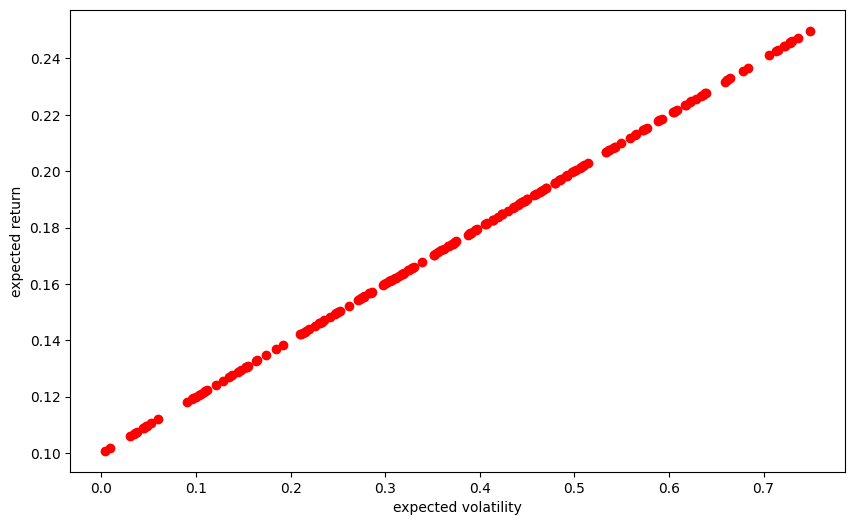

In [8]:
import matplotlib.pyplot as plt

# 무작위 포트폴리오 비율을 생성 (몬테카를로 시뮬레이션)
# phi_mcs: (2, 200) 크기의 배열을 생성하여 200개의 포트폴리오에 대해 주식과 채권 비율을 무작위로 설정
phi_mcs = np.random.random((2, 200))

# 각 포트폴리오에 대해 주식과 채권의 비율을 합이 1이 되도록 정규화
# phi_mcs.sum(axis=0): 각 열(포트폴리오)마다 주식과 채권의 비율 합을 구함
# phi_mcs / phi_mcs.sum(axis=0): 각 포트폴리오의 주식과 채권 비율을 합이 1이 되도록 나눔
# .T: 결과를 전치하여 200개의 포트폴리오가 각각 행에 위치하도록 함
phi_mcs = (phi_mcs / phi_mcs.sum(axis=0)).T

# 몬테카를로 시뮬레이션으로 각 포트폴리오의 변동성과 기대 수익률을 계산
# mcs: 200개의 포트폴리오에 대해 sigma_phi (변동성)와 mu_phi (기대 수익률)를 계산하여 저장
# 리스트 내포식을 사용하여 각 포트폴리오의 변동성과 기대 수익률을 쌍으로 저장 (각 phi에 대해 sigma_phi, mu_phi 계산)
mcs = np.array([(sigma_phi(phi), mu_phi(phi)) for phi in phi_mcs])

# 그래프를 그리기 위한 figure 설정 (크기: 10x6)
plt.figure(figsize=(10, 6))

# 포트폴리오의 변동성(표준편차)과 기대 수익률을 산점도로 플로팅
# mcs[:, 0]: 포트폴리오의 변동성 (첫 번째 열)
# mcs[:, 1]: 포트폴리오의 기대 수익률 (두 번째 열)
# 'ro': 빨간색 원으로 표시
plt.plot(mcs[:, 0], mcs[:, 1], 'ro')

# x축 라벨 설정 (변동성)
plt.xlabel('expected volatility')

# y축 라벨 설정 (기대 수익률)
plt.ylabel('expected return')

- 위험 자산이 2개인 경우의 시뮬레이션

Text(0, 0.5, 'expected return')

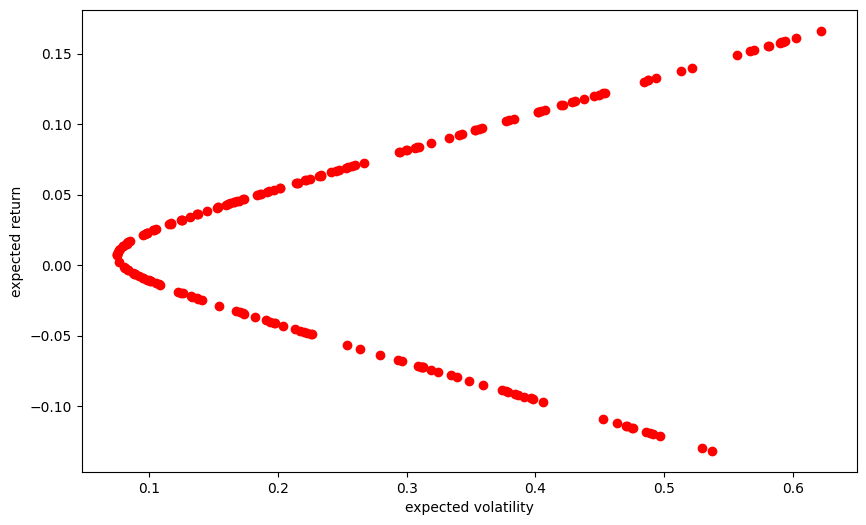

In [9]:
# 새로운 확률 측도 P 설정 (3개의 상태에 대해 각 상태의 확률을 1/3로 설정)
P = np.ones(3) / 3  # P = [1/3, 1/3, 1/3]

# 시점 1에서 주식 가격 배열 설정 (3개의 상태에서 주식의 미래 가격)
S1 = np.array((20, 10, 5))  # 상태 1: 20, 상태 2: 10, 상태 3: 5

# 시점 0에서 채권(T)의 가격 설정 (채권의 현재 가격)
T0 = 10  # 현재 채권 가격

# 시점 1에서 채권(T)의 가격 배열 설정 (3개의 상태에서 채권의 미래 가격)
T1 = np.array((1, 12, 13))  # 상태 1: 1, 상태 2: 12, 상태 3: 13

# 시점 0에서 주식과 채권의 가격 벡터 설정
M0 = np.array((S0, T0))  # 현재 주식 가격 S0와 채권 가격 T0

# 시점 1에서 주식과 채권의 가격 행렬 설정 (각 상태에서 주식과 채권의 가격을 전치하여 행렬로 만듦)
M1 = np.array((S1, T1)).T  # 미래의 주식(S1)과 채권(T1) 가격을 전치하여 각 상태별로 정리

# 수익률 행렬 계산 (미래 가격 M1에서 현재 가격 M0을 나누고 1을 뺀 값으로 수익률을 계산)
rM = M1 / M0 - 1  # 자산의 수익률 행렬

# 각 포트폴리오 비율에 대해 변동성과 기대 수익률을 계산 (phi_mcs에 대한 몬테카를로 시뮬레이션)
mcs = np.array([(sigma_phi(phi), mu_phi(phi)) for phi in phi_mcs])

# 포트폴리오 변동성과 기대 수익률을 플롯하기 위한 figure 설정 (크기: 10x6)
plt.figure(figsize=(10, 6))

# 포트폴리오 변동성(표준편차)과 기대 수익률 산점도
# mcs[:, 0]: 포트폴리오의 변동성 (첫 번째 열)
# mcs[:, 1]: 포트폴리오의 기대 수익률 (두 번째 열)
# 'ro': 빨간색 원으로 표시
plt.plot(mcs[:, 0], mcs[:, 1], 'ro')

# x축 라벨 설정 (변동성)
plt.xlabel('expected volatility')

# y축 라벨 설정 (기대 수익률)
plt.ylabel('expected return')

## 최소 변동성 및 최대 샤프 비율
- 리스크-수익률 공간에서 두 포트폴리오의 위치를 보여줌
- 위험 자산 T는 기대 수익률이 마이너스이지만, 최대 샤프 비율 포트폴리에서는 비중이 높음
- 이는 다변화 효과로 인해 포트폴리오의 예상 수익률보다 포트폴리오 리스크가 더 낮아졌기 때문임

In [10]:
from scipy.optimize import minimize

# 샤프 비율 함수 정의
# 포트폴리오의 샤프 비율을 계산 (기대 수익률 / 변동성)
# 샤프 비율은 위험 대비 수익률을 나타내는 지표로, 높을수록 좋음
def sharpe(phi):
    return mu_phi(phi) / sigma_phi(phi)

# 제약 조건 설정
# 포트폴리오의 주식과 채권 비율의 합이 1이 되도록 하는 제약 조건
cons = {'type': 'eq', 'fun': lambda phi: np.sum(phi) - 1}

# 비율의 경계 설정
# 주식과 채권의 비율이 각각 0에서 1 사이에 있어야 한다는 경계 설정
bnds = ((0, 1), (0, 1))

# 포트폴리오 변동성 최소화
# sigma_phi: 포트폴리오의 변동성(표준편차)을 최소화하는 최적의 비율을 찾음
# 초기 추정치는 주식과 채권을 각각 50%로 설정 (0.5, 0.5)
# 제약 조건(cons)과 경계 조건(bnds)을 적용하여 최적화 수행
min_var = minimize(sigma_phi, (0.5, 0.5), constraints=cons, bounds=bnds)

# 최적화 결과 출력 (변동성을 최소화하는 포트폴리오 비율)
print(min_var)

# 샤프 비율 최대화
# 샤프 비율을 최대화하기 위해 음의 샤프 비율을 최소화하는 방식으로 최적화 수행
# 샤프 비율은 기본적으로 높은 것이 유리하므로, 이를 최대화하려면 음수를 최소화하는 방향으로 설정
# 초기 추정치는 주식과 채권을 각각 50%로 설정 (0.5, 0.5)
# 제약 조건(cons)과 경계 조건(bnds)을 적용하여 최적화 수행
max_sharpe = minimize(lambda phi: -sharpe(phi), (0.5, 0.5), constraints=cons, bounds=bnds)

# 최적화 결과 출력 (샤프 비율을 최대화하는 포트폴리오 비율)
print(max_sharpe)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.07481322946903253
       x: [ 4.651e-01  5.349e-01]
     nit: 4
     jac: [ 7.427e-02  7.529e-02]
    nfev: 13
    njev: 4
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.27216540990230487
       x: [ 6.673e-01  3.327e-01]
     nit: 9
     jac: [ 1.205e-04 -2.417e-04]
    nfev: 29
    njev: 9


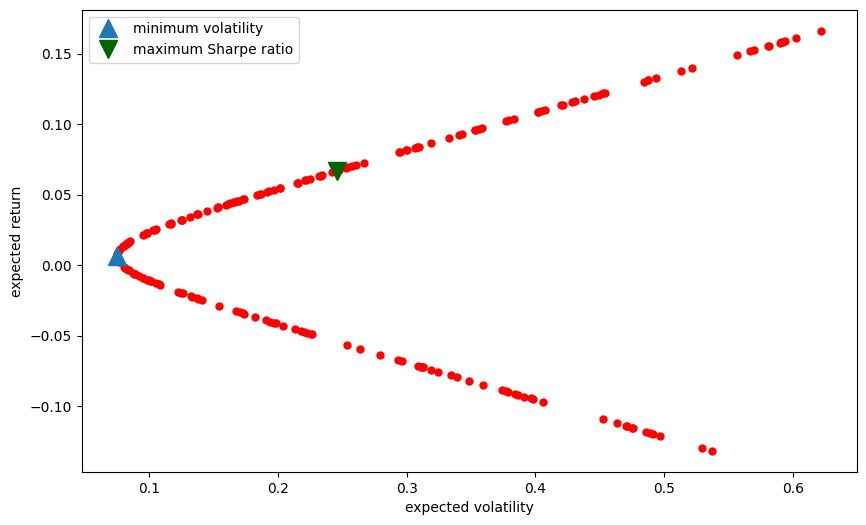

In [11]:
plt.figure(figsize=(10, 6))

# 기존 포트폴리오의 변동성과 기대 수익률을 산점도로 플롯 (빨간색 원, ms=5는 마커 크기)
plt.plot(mcs[:, 0], mcs[:, 1], 'ro', ms=5)

# 최소 변동성 포트폴리오의 변동성과 기대 수익률을 플롯 (삼각형 마커 '^', 크기 12.5)
plt.plot(sigma_phi(min_var['x']), mu_phi(min_var['x']),
         '^', ms=12.5, label='minimum volatility')

# 최대 샤프 비율 포트폴리오의 변동성과 기대 수익률을 플롯 (삼각형 마커 'v', 크기 12.5, 다크 초록색)
plt.plot(sigma_phi(max_sharpe['x']), mu_phi(max_sharpe['x']),
         'v', ms=12.5, color='darkgreen', label='maximum Sharpe ratio')

# x축 라벨 설정 (변동성)
plt.xlabel('expected volatility')

# y축 라벨 설정 (기대 수익률)
plt.ylabel('expected return')

# 범례 표시
plt.legend()

## 효율적 투자 경계선
- 예상되는 리스크를 고려할 때 최대의 기대수익을 가지는 포트폴리오
- 최소 위험 포트폴리오보다 낮은 기대 수익률을 보이는 모든 포트폴리오는 비효율적
- 리스크-수익률 공간에서 효율적인 포트폴리오 도출
- 효율적인 모든 포트폴리오 집합을 효율적 투자 경계선이라고 하며, 투자자는 효율적 투자 경계선에 있는 포트폴리오만 선택

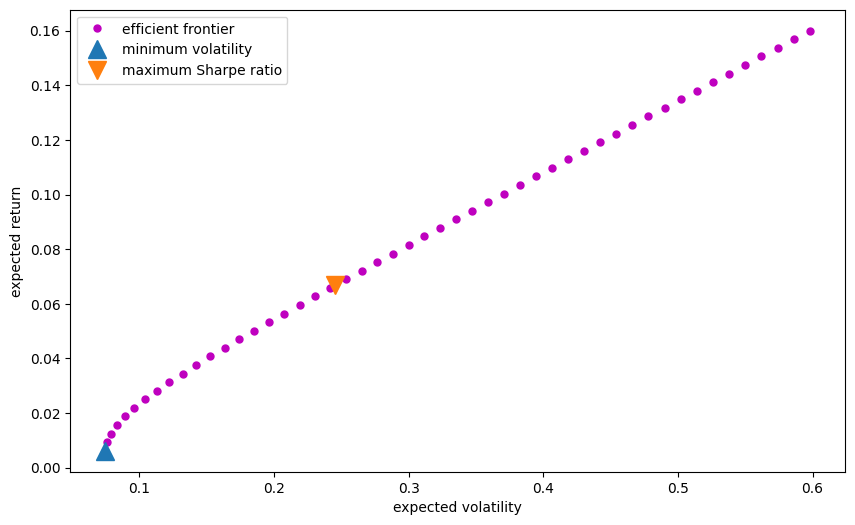

In [12]:
# 제안 조건으로 기대 수익률 목표값 설정
# 첫 번째 제약 조건: 주식과 채권 비율의 합이 1이 되어야 함
# 두 번째 제약 조건: 주어진 목표 기대 수익률(target)에 맞춰 포트폴리오의 기대 수익률이 같도록 설정
cons = [{'type': 'eq', 'fun': lambda phi: np.sum(phi) - 1},
        {'type': 'eq', 'fun': lambda phi: mu_phi(phi) - target}]

# 비율 경계 설정: 주식과 채권의 비율이 각각 0에서 1 사이에 있어야 함
bnds = ((0, 1), (0, 1))

# 목표 기대 수익률 집합 생성
# np.linspace를 사용해 최소 변동성 포트폴리오의 기대 수익률부터 0.16까지 목표 기대 수익률(targets)을 생성
targets = np.linspace(mu_phi(min_var['x']), 0.16)

# 주어진 기대 수익률에 대해 가장 변동성이 작은 포트폴리오 선택
frontier = []  # 효율적 프론티어를 저장할 리스트

# 각 목표 기대 수익률에 대해 포트폴리오의 최소 변동성을 계산
for target in targets:
    # 주어진 목표 기대 수익률(target)에 대해 변동성이 최소가 되는 포트폴리오 비율 phi_eff를 계산
    phi_eff = minimize(sigma_phi, (0.5, 0.5), constraints=cons, bounds=bnds)['x']
    # 계산된 포트폴리오 비율로부터 변동성과 기대 수익률을 구하여 frontier에 추가
    frontier.append((sigma_phi(phi_eff), mu_phi(phi_eff)))

# frontier 리스트를 배열로 변환하여 사용
frontier = np.array(frontier)

# 그래프 설정
plt.figure(figsize=(10, 6))

# 효율적 프론티어를 마젠타색 원으로 플롯 (ms=5: 마커 크기)
# frontier[:, 0]: 변동성(표준편차), frontier[:, 1]: 기대 수익률
plt.plot(frontier[:, 0], frontier[:, 1], 'mo', ms=5, label='efficient frontier')

# 최소 변동성 포트폴리오를 삼각형 마커로 플롯 (ms=12.5: 마커 크기)
plt.plot(sigma_phi(min_var['x']), mu_phi(min_var['x']),
         '^', ms=12.5, label='minimum volatility')

# 최대 샤프 비율 포트폴리오를 역삼각형 마커로 플롯 (ms=12.5: 마커 크기)
plt.plot(sigma_phi(max_sharpe['x']), mu_phi(max_sharpe['x']),
         'v', ms=12.5, label='maximum Sharpe ratio')

# x축 라벨 설정 (expected volatility: 변동성)
plt.xlabel('expected volatility')

# y축 라벨 설정 (expected return: 기대 수익률)
plt.ylabel('expected return')

# 범례 표시
plt.legend()

## 자본자산 가격결정 모형
- 이 그래프는 **자본자산가격결정모형 (CAPM)**에서 **자본시장선 (Capital Market Line, CML)**을 나타낸 것.
- 자본시장선은 효율적 자산의 포트폴리오에 대한 기대 수익과 리스크 간의 관계를 보여줌.

### Capital Market Line (자본시장선)
- 그래프에서 직선으로 나타나며, 무위험 자산과 시장 포트폴리오 간의 결합으로 얻을 수 있는 최적 포트폴리오의 조합을 나타내며, 직선은 무위험 자산에서 시작하여 시장 포트폴리오를 통과함.

### Risk-free Asset (무위험 자산)
- 그래프의 좌하단에 있는 점. 수익률이 $(0, \bar{r})$로 표시된 무위험 자산을 나타냅니다. 즉, 변동성(리스크)이 0이고, 수익률은 고정된 $\bar{r}$입니다.
- 여기서는 무위험 자산의 수익률이 0.01로 나타나 있음.

### Market Portfolio (시장 포트폴리오)
- 그래프에서 삼각형 모양으로 나타난 점으로, 시장 포트폴리오를 나타내며. 이 점은 변동성(리스크), $\sigma_M$와 기대수익률 $\mu_M$의 조합을 보여줌.
- 여기서는 변동성이 0.2, 기대 수익률이 0.15임



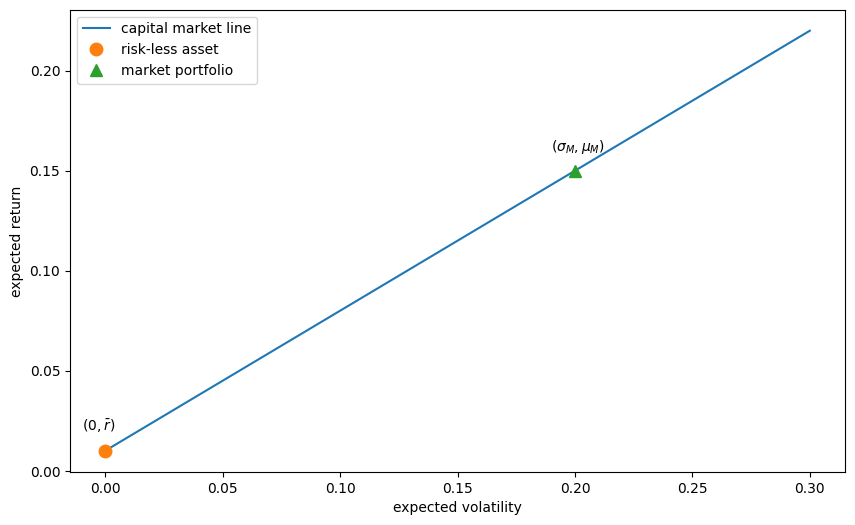

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot((0, 0.3), (0.01, 0.22), label='capital market line')
plt.plot(0, 0.01, 'o', ms=9, label='risk-less asset')
plt.plot(0.2, 0.15, '^', ms=9, label='market portfolio')
plt.annotate('$(0, \\bar{r})$', (0, 0.01), (-0.01, 0.02))
plt.annotate('$(\sigma_M, \mu_M)$', (0.2, 0.15), (0.19, 0.16))
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.legend();

### 자본자산 가격결졍 모형 - 자본 시장선
- 무위험 수익률

In [14]:
phi_M = np.array((0.8, 0.2))
mu_M = mu_phi(phi_M)
mu_M

0.10666666666666666

In [15]:
sigma_M = sigma_phi(phi_M)
sigma_M

0.39474323581566567

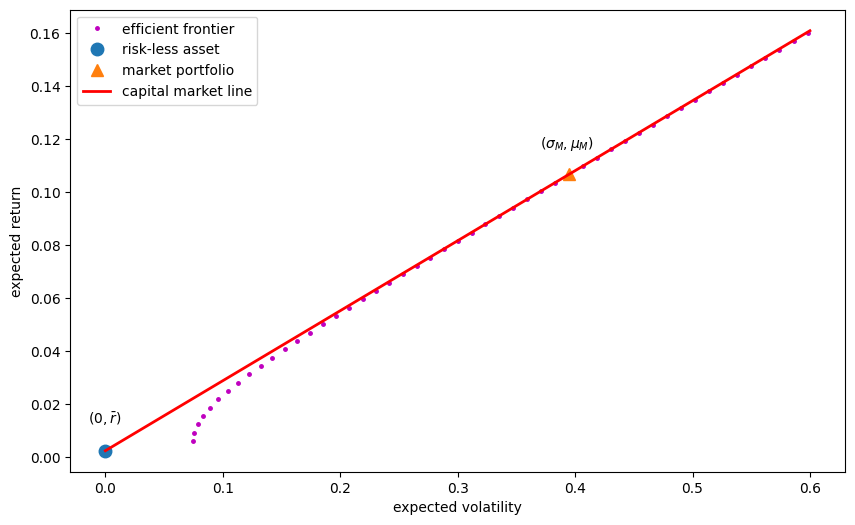

In [16]:
import matplotlib.pyplot as plt

r = 0.0025
plt.figure(figsize=(10, 6))
plt.plot(frontier[:, 0], frontier[:, 1], 'm.', ms=5,
         label='efficient frontier')
plt.plot(0, r, 'o', ms=9, label='risk-less asset')
plt.plot(sigma_M, mu_M, '^', ms=9, label='market portfolio')
plt.plot((0, 0.6), (r, r + ((mu_M - r) / sigma_M) * 0.6),
         'r', label='capital market line', lw=2.0)
plt.annotate('$(0, \\bar{r})$', (0, r), (-0.015, r + 0.01))
plt.annotate('$(\sigma_M, \mu_M)$', (sigma_M, mu_M),
             (sigma_M - 0.025, mu_M + 0.01))
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.legend();

### 최적 포트폴리오

In [17]:
def U(p):
    mu, sigma = p
    return mu - 1 / 2 * (sigma ** 2 + mu ** 2)

cons = {'type': 'eq',
        'fun': lambda p: p[0] - (r + (mu_M - r) / sigma_M * p[1])}

opt = minimize(lambda p: -U(p), (0.1, 0.3), constraints=cons)
opt

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.034885186826739426
       x: [ 6.744e-02  2.461e-01]
     nit: 2
     jac: [-9.326e-01  2.461e-01]
    nfev: 6
    njev: 2

### 무차별 곡선

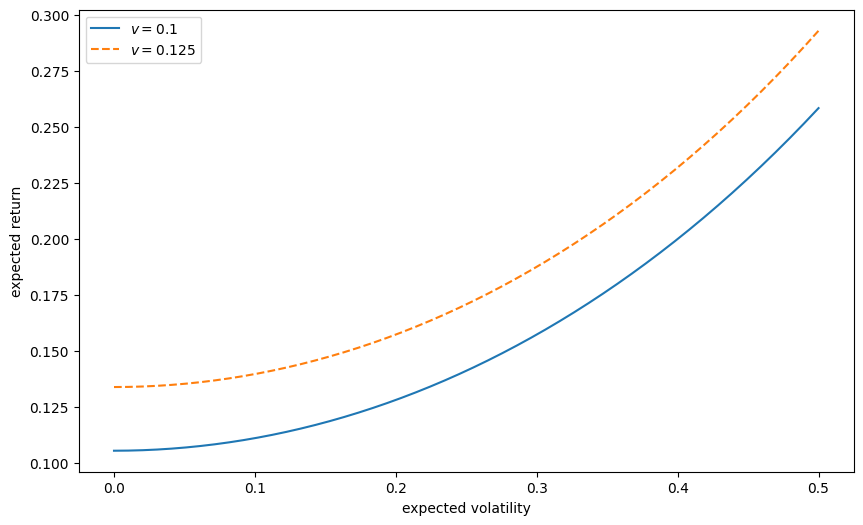

In [18]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

# SymPy의 init_printing을 사용하여 출력을 텍스트 형식으로 설정
init_printing(use_unicode=False, use_latex=False)

# μ(기대수익), σ(변동성), b, v를 심볼릭 변수로 정의
mu, sigma, b, v = symbols('mu sigma b v')

# 방정식을 μ에 대해서 풀기
# 방정식: mu - (b/2) * (sigma^2 + mu^2) - v = 0
# 이는 μ와 σ 사이의 관계를 나타내며, SymPy를 사용해 μ에 대한 해를 구합니다.
sol = solve('mu - b / 2 * (sigma ** 2 + mu ** 2) - v', mu)

# 해 중 첫 번째 해 선택 후, 특정 값으로 치환 (b = 1, v = 0.1)
# 이는 주어진 b와 v의 값에 대해 기대 수익 μ와 변동성 σ 간의 관계를 구하는 단계입니다.
u1 = sol[0].subs({'b': 1, 'v': 0.1})

# 두 번째 조건 (b = 1, v = 0.125)로 동일한 방정식의 해를 구함
u2 = sol[0].subs({'b': 1, 'v': 0.125})

# SymPy 식을 lambdify를 사용하여 NumPy의 함수로 변환
# lambdify를 사용하면 SymPy로 생성된 수식을 NumPy 함수처럼 사용할 수 있습니다.
f1 = lambdify(sigma, u1)  # σ를 입력받아 μ 값을 계산하는 함수 f1
f2 = lambdify(sigma, u2)  # σ를 입력받아 μ 값을 계산하는 함수 f2

# σ(변동성)의 값을 0.0에서 0.5까지 생성 (100개의 점으로 나누어 생성)
sigma_ = np.linspace(0.0, 0.5)

# 각각의 f1, f2 함수로 μ 값 계산
u1_ = f1(sigma_)  # 첫 번째 경우 (v = 0.1)에 대한 μ 값
u2_ = f2(sigma_)  # 두 번째 경우 (v = 0.125)에 대한 μ 값

# 결과 시각화를 위해 Matplotlib 사용
plt.figure(figsize=(10, 6))  # 그래프의 크기를 설정 (가로 10, 세로 6)
plt.plot(sigma_, u1_, label='$v=0.1$')  # 첫 번째 경우를 실선으로 플롯
plt.plot(sigma_, u2_, '--', label='$v=0.125$')  # 두 번째 경우를 점선으로 플롯
plt.xlabel('expected volatility')  # x축 라벨을 'expected volatility(기대 변동성)'으로 설정
plt.ylabel('expected return')  # y축 라벨을 'expected return(기대 수익률)'으로 설정
plt.legend()  # 범례를 추가하여 v=0.1과 v=0.125에 해당하는 선을 구분
plt.show()  # 그래프를 화면에 출력


### 자본시장선에 대한 최적 포트폴리오

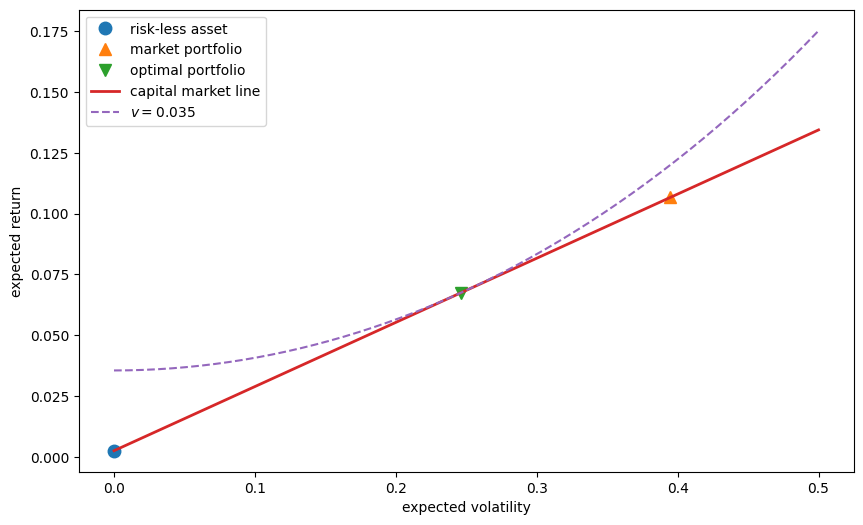

In [19]:
u = sol[0].subs({'b': 1, 'v': -opt['fun']})  # 방정식의 첫 번째 해에 b=1, v에 -opt['fun'] 값을 대입
f = lambdify(sigma, u)  # SymPy 식을 NumPy 함수로 변환하여 σ에 대한 μ를 계산할 수 있게 만듦
u_ = f(sigma_)  # 주어진 σ 값에 따라 μ 값을 계산

plt.figure(figsize=(10, 6))  # 그래프 크기 설정 (가로 10, 세로 6)

# 무위험 자산을 그래프에 표시 (점으로 나타냄)
plt.plot(0, r, 'o', ms=9, label='risk-less asset')  # 무위험 자산 (리스크 0, 수익 r)

# 시장 포트폴리오 (삼각형으로 표시)
plt.plot(sigma_M, mu_M, '^', ms=9, label='market portfolio')  # 시장 포트폴리오 (변동성 σ_M, 수익률 μ_M)

# 최적 포트폴리오 (역삼각형으로 표시)
plt.plot(opt['x'][1], opt['x'][0], 'v', ms=9, label='optimal portfolio')
# 최적 포트폴리오 (opt['x'][1] = 변동성, opt['x'][0] = 수익률)

# 자본시장선을 그리기
plt.plot((0, 0.5), (r, r + (mu_M - r) / sigma_M * 0.5),
         label='capital market line', lw=2.0)
# 자본시장선(CML)은 무위험 자산에서 시장 포트폴리오를 연결하는 직선
# CML의 기울기 = (시장 포트폴리오 수익률 μ_M - 무위험 자산 수익률 r) / 시장 포트폴리오 변동성 σ_M

# 특정 v 값에 대한 기대 수익률(μ) 곡선 (점선으로 표시)
plt.plot(sigma_, u_, '--', label='$v={}$'.format(-round(opt['fun'], 3)))
# 최적해(optimal solution)에서 계산된 v에 대한 곡선

plt.xlabel('expected volatility')  # x축 라벨을 "expected volatility(기대 변동성)"으로 설정
plt.ylabel('expected return')  # y축 라벨을 "expected return(기대 수익률)"으로 설정
plt.legend()  # 범례를 추가하여 그래프의 각 요소를 설명
plt.show()  # 그래프 출력

## 차익거래 가격결정 이론
-

# PART-2 머신러닝

In [20]:
import lightgbm as lgb

lgb.__version__

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


'4.5.0'

### 주식 가격 데이터 로드 및 전처리

In [27]:
# yfinance와 pandas, numpy를 가져옵니다.
import yfinance as yf  # Yahoo Finance API를 사용하여 금융 데이터를 가져오기 위한 라이브러리
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리
import numpy as np  # 고급 수학 함수와 배열 처리를 위한 라이브러리

# 1. TSLA 주식 데이터 가져오기 (최근 1년)
def load_data():
    # TSLA(테슬라)의 주식 데이터를 Yahoo Finance에서 다운로드합니다.
    # 데이터는 2023년 1월 1일부터 2024년 9월 28일까지의 기간으로 설정합니다.
    # 여기 부분을 조정하기
    data = yf.download('TSLA', start="2020-01-01", end="2024-12-31")
    data.columns = data.columns.droplevel(1)  # 'Ticker' 레벨 제거
    data = data.rename_axis(None, axis=1)  # 컬럼 축 이름 제거

    # 'Close' 열(종가)의 다음 날 값을 'Target' 열로 생성하여 예측의 목표로 설정합니다.
    data['Target'] = data['Close'].shift(-1)  # shift(-1)은 한 칸 위로 값을 이동시킵니다.

    # 데이터의 결측값을 제거합니다. 'Target' 열이 NaN인 마지막 행이 제거됩니다.
    data.dropna(inplace=True)  # 결측값 제거를 위해 in-place 옵션 사용

    return data  # 처리된 데이터를 반환합니다.

# 데이터 로드
data = load_data()  # load_data() 함수를 호출하여 TSLA 데이터를 로드합니다.
print(data.head())  # 데이터의 첫 5개 행을 출력하여 로드된 데이터의 구조를 확인합니다.
print(data.tail()) # 데이터의 마지막 5개 행을 출력하여 로드된 데이터의 구조를 확인합니다.

[*********************100%***********************]  1 of 1 completed

                Close       High        Low       Open     Volume     Target
Date                                                                        
2020-01-02  28.684000  28.713333  28.114000  28.299999  142981500  29.534000
2020-01-03  29.534000  30.266666  29.128000  29.366667  266677500  30.102667
2020-01-06  30.102667  30.104000  29.333332  29.364668  151995000  31.270666
2020-01-07  31.270666  31.441999  30.224001  30.760000  268231500  32.809334
2020-01-08  32.809334  33.232666  31.215334  31.580000  467164500  32.089333
                 Close        High         Low        Open     Volume  \
Date                                                                    
2024-12-20  421.059998  447.079987  417.640015  425.510010  132216200   
2024-12-23  430.600006  434.510010  415.410004  431.000000   72698100   
2024-12-24  462.279999  462.779999  435.140015  435.899994   59551800   
2024-12-26  454.130005  465.329987  451.019989  465.160004   76366400   
2024-12-27  431.660004 

### 특성 생성 (이동 평균, 가격 차분 등)

In [28]:
# 특성 생성: 이동 평균, 가격 차분 등
def feature_engineering(data):
    # 5일 이동 평균을 계산하여 'MA_5' 열에 저장합니다.
    # rolling(window=5): 5일을 기준으로 이동 평균을 계산
    data['MA_5'] = data['Close'].rolling(window=5).mean()

    # 20일 이동 평균을 계산하여 'MA_20' 열에 저장합니다.
    # rolling(window=20): 20일을 기준으로 이동 평균을 계산
    data['MA_20'] = data['Close'].rolling(window=20).mean()

    # 현재 종가와 이전 종가 간의 차이를 계산하여 'Price_Diff' 열에 저장합니다.
    # diff(): 현재 행과 이전 행의 차이를 계산
    data['Price_Diff'] = data['Close'].diff()

    # 데이터의 결측값을 제거합니다. 이동 평균 및 차분 연산으로 인해 NaN이 발생할 수 있습니다.
    data.dropna(inplace=True)  # 결측값 제거를 위해 in-place 옵션 사용

    return data  # 처리된 데이터를 반환합니다.

# 특성 엔지니어링
data = feature_engineering(data)  # feature_engineering() 함수를 호출하여 특성을 생성하고 데이터에 추가합니다.
print(data.head())  # 데이터의 첫 5개 행을 출력하여 생성된 특성을 확인합니다.

                Close       High        Low       Open     Volume     Target  \
Date                                                                           
2020-01-30  42.720669  43.391998  41.200001  42.161331  435085500  43.371334   
2020-01-31  43.371334  43.533333  42.167999  42.666668  235789500  52.000000   
2020-02-03  52.000000  52.409332  44.901333  44.912666  705975000  59.137333   
2020-02-04  59.137333  64.599335  55.591999  58.863998  914082000  48.980000   
2020-02-05  48.980000  56.398666  46.940666  54.883999  726357000  49.930668   

                 MA_5      MA_20  Price_Diff  
Date                                          
2020-01-30  38.820533  34.837566    3.988003  
2020-01-31  39.963866  35.571933    0.650665  
2020-02-03  42.923600  36.695233    8.628666  
2020-02-04  47.192400  38.146966    7.137333  
2020-02-05  49.241867  39.032433  -10.157333  


### LightGBM 모델 학습

In [29]:
# 필요한 라이브러리를 가져옵니다.
import pandas as pd  # 데이터 조작을 위한 라이브러리
from lightgbm import LGBMRegressor  # LightGBM 모델을 사용하기 위한 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # 데이터 분할 및 하이퍼파라미터 탐색을 위한 함수
from sklearn.metrics import mean_squared_error  # 모델 성능 평가를 위한 함수
import numpy as np  # 고급 수학 함수와 배열 처리를 위한 라이브러리

# LightGBM 모델 학습 및 하이퍼파라미터 튜닝 (RandomizedSearchCV)
def train_lightgbm_with_random_tuning(data):
    # 입력 변수(X)와 타겟 변수(y) 설정
    X = data[['Close', 'Volume', 'MA_5', 'MA_20', 'Price_Diff']]  # 모델에 사용할 입력 변수
    y = data['Target']  # 예측할 타겟 변수 (다음 날 종가)

    # 데이터셋을 학습용과 테스트용으로 분할 (80% 학습, 20% 테스트)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 시계열 머신러닝 모형의 전통적인 방식 예시 : 1년치 데이터
    # 1월~10월 : 훈련데이터
    # 11월 : 검증데이터
    # 12월 : 테스트데이터

    # 하이퍼파라미터의 랜덤 탐색 범위 설정
    param_dist = {
        'n_estimators': np.arange(50, 300, 50),  # 트리의 개수
        'learning_rate': np.linspace(0.01, 0.3, 10),  # 학습률
        'num_leaves': np.arange(20, 150, 10),  # 리프 노드의 개수
        # 'max_depth': np.arange(-1, 20, 5),  # 최대 깊이 (-1은 제한 없음)
        'subsample': np.linspace(0.5, 1, 5),  # 샘플링 비율
        'colsample_bytree': np.linspace(0.5, 1, 5)  # 각 트리에서 사용할 특성의 비율
    }

    # LinearRegression
    # DecisionTree
    # Randomforest

    # LightGBM 모델 인스턴스 생성
    model = LGBMRegressor()

    # RandomizedSearchCV를 사용하여 하이퍼파라미터 튜닝을 수행
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                       n_iter=50, scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42)

    # 학습 데이터로 모델 학습
    random_search.fit(X_train, y_train)

    # 최적의 모델로 예측 수행
    best_model = random_search.best_estimator_  # 최적 하이퍼파라미터로 학습된 모델
    y_pred = best_model.predict(X_test)  # 테스트 데이터에 대한 예측 수행

    # 성능 평가: RMSE(루트 평균 제곱 오차) 계산
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # 예측 결과와 실제 값을 기반으로 RMSE 계산
    print(f'Best Model RMSE: {rmse:.4f}')  # RMSE 결과 출력

    # 결과 DataFrame 생성: RandomizedSearchCV의 결과를 DataFrame으로 변환
    results_df = pd.DataFrame(random_search.cv_results_)

    return best_model, X_test, y_test, y_pred, results_df  # 최적 모델, 테스트 데이터, 예측 결과, 결과 DataFrame 반환

# LightGBM 모델 학습 및 하이퍼파라미터 튜닝 호출
model, X_test, y_test, y_pred, results_df = train_lightgbm_with_random_tuning(data)

# 결과를 Excel 파일로 저장: 튜닝 결과를 Excel 파일로 저장
results_df.to_excel('lightgbm_random_tuning_results.xlsx', index=False)
print("Hyperparameter tuning results have been saved to 'lightgbm_random_tuning_results.xlsx'.")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

#### 주식 가격 예측 비교

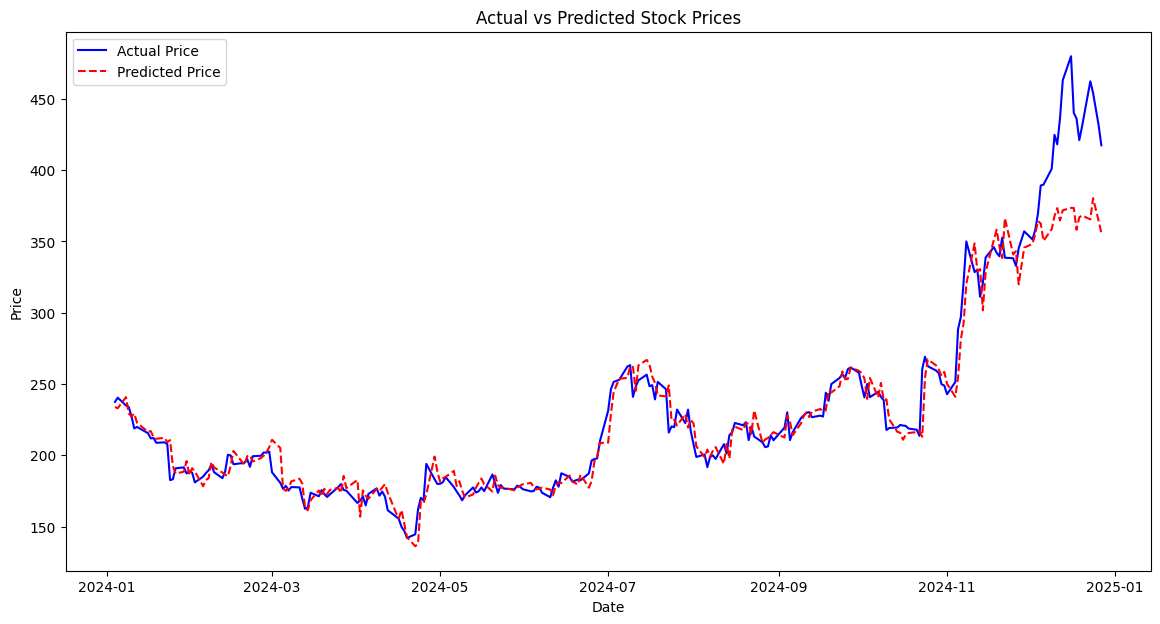

In [30]:
# Matplotlib 라이브러리를 가져옵니다.
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리

# 실제 데이터와 예측 데이터 비교 및 시각화 함수 정의
def plot_actual_vs_predicted(y_test, y_pred):
    # 그래프의 크기를 설정합니다.
    plt.figure(figsize=(14, 7))  # 가로 14, 세로 7 인치의 그래프 크기 설정

    # 실제 값과 예측 값 비교
    plt.plot(y_test.index, y_test.values, label="Actual Price", color='blue')  # 실제 가격을 파란색 선으로 그립니다.
    plt.plot(y_test.index, y_pred, label="Predicted Price", color='red', linestyle='--')  # 예측 가격을 빨간색 점선으로 그립니다.

    # 그래프 제목과 축 레이블 설정
    plt.title('Actual vs Predicted Stock Prices')  # 그래프 제목
    plt.xlabel('Date')  # x축 레이블: 날짜
    plt.ylabel('Price')  # y축 레이블: 가격
    plt.legend()  # 범례 표시 (각 선의 설명을 표시)

    # 그래프를 화면에 표시합니다.
    plt.show()

# 시각화 실행: 실제 가격과 예측 가격을 비교하여 시각화합니다.
plot_actual_vs_predicted(y_test, y_pred)


## 딥러닝 모델

In [31]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [32]:
# 필요한 라이브러리를 가져옵니다.
import tensorflow as tf  # TensorFlow 라이브러리
from sklearn.preprocessing import MinMaxScaler  # 데이터 스케일링을 위한 라이브러리
from tensorflow.keras.models import Sequential  # Sequential 모델을 생성하기 위한 클래스
from tensorflow.keras.layers import LSTM, Dense, Dropout  # LSTM, Dense, Dropout 레이어
from kerastuner import RandomSearch  # Keras Tuner를 사용하여 하이퍼파라미터 튜닝을 위한 클래스

# 데이터 스케일링 (정규화)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']])

# 입력 데이터 준비 (LSTM 입력 형태로 변환)
def prepare_data(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = prepare_data(scaled_data, time_step)

# LSTM 입력 형식으로 변환 (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Keras Tuner를 사용한 하이퍼파라미터 튜닝
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_units', min_value=25, max_value=100, step=25)))
    model.add(Dense(1))  # 다음 날 종가 예측

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Keras Tuner 설정
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner_dir',
    project_name='stock_price_prediction'
)

# 하이퍼파라미터 튜닝 실행
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# 최적의 하이퍼파라미터 선택
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# 최적의 하이퍼파라미터로 모델 빌드
model = tuner.hypermodel.build(best_hps)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# 예측 수행
y_pred = model.predict(X_test)

# 스케일 복원 (예측 값과 실제 값을 스케일에서 원래 값으로 변환)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

Trial 5 Complete [00h 05m 03s]
val_loss: 0.0007852810861853262

Best val_loss So Far: 0.0006518492591567338
Total elapsed time: 00h 18m 50s
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 324ms/step - loss: 0.0404 - val_loss: 0.0012
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - loss: 0.0024 - val_loss: 9.3578e-04
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - loss: 0.0020 - val_loss: 7.8923e-04
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - loss: 0.0020 - val_loss: 6.8878e-04
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - loss: 0.0014 - val_loss: 8.0289e-04
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - loss: 0.0015 - val_loss: 6.5109e-04
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - loss: 0.0013 - val_loss: 6.4881e-04
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - l

- 아래 코드는 실행 시간이 매우 김

In [33]:
"""

# 필요한 라이브러리를 가져옵니다.
import tensorflow as tf  # TensorFlow 라이브러리
from sklearn.preprocessing import MinMaxScaler  # 데이터 스케일링을 위한 라이브러리
from tensorflow.keras.models import Sequential  # Sequential 모델을 생성하기 위한 클래스
from tensorflow.keras.layers import LSTM, Dense, Dropout  # LSTM, Dense, Dropout 레이어
from kerastuner import RandomSearch  # Keras Tuner를 사용하여 하이퍼파라미터 튜닝을 위한 클래스

# 데이터 스케일링
scaler = MinMaxScaler()  # MinMaxScaler 인스턴스 생성
scaled_data = scaler.fit_transform(data[['Close']])  # 종가 데이터를 0과 1 사이로 스케일링

# 입력 데이터 준비 (LSTM 입력 형태로 변환)
def prepare_data(data, time_step=60):
    X, y = [], []  # 입력(X)와 타겟(y) 리스트 초기화
    for i in range(len(data) - time_step):  # time_step 길이만큼 슬라이싱
        X.append(data[i:i+time_step, 0])  # 입력 데이터 추가
        y.append(data[i + time_step, 0])  # 타겟 데이터 추가
    return np.array(X), np.array(y)  # 배열로 변환하여 반환

time_step = 60  # 입력으로 사용할 시간 단계 설정
X, y = prepare_data(scaled_data, time_step)  # 입력 데이터(X)와 타겟(y) 준비

# LSTM 입력 형식으로 변환 (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM 모델 입력에 맞게 데이터 차원 변경

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # 훈련과 테스트 데이터 분할

# 모델 구조 정의
def build_model(hp):
    model = Sequential()  # Sequential 모델 생성
    # 첫 번째 LSTM 레이어 추가
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))  # 드롭아웃 레이어 추가
    # 두 번째 LSTM 레이어 추가
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))  # 드롭아웃 레이어 추가
    model.add(Dense(units=hp.Int('dense_units', min_value=10, max_value=100, step=10)))  # Dense 레이어 추가
    model.add(Dense(units=1))  # 출력 레이어 추가
    model.compile(optimizer='adam', loss='mean_squared_error')  # 모델 컴파일 (손실 함수: 평균 제곱 오차)
    return model  # 모델 반환

# 하이퍼파라미터 튜닝 설정
tuner = RandomSearch(build_model, objective='val_loss', max_trials=5, executions_per_trial=3, directory='my_dir', project_name='LSTM_tuning')
tuner.search(X_train, y_train, epochs=20, validation_split=0.1)  # 하이퍼파라미터 탐색 시작

# 최적의 하이퍼파라미터 선택
best_hps = tuner.get_best_hyperparameters()[0]  # 최적 하이퍼파라미터 가져오기

# 최적의 하이퍼파라미터로 모델 빌드
model = tuner.hypermodel.build(best_hps)  # 최적 하이퍼파라미터로 모델 생성

# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)  # 모델 학습

# 예측 수행
y_pred = model.predict(X_test)  # 테스트 데이터에 대한 예측 수행

# 스케일 복원 (예측 값과 실제 값을 스케일에서 원래 값으로 변환)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # 테스트 타겟을 원래 스케일로 복원
y_pred = scaler.inverse_transform(y_pred)  # 예측 값을 원래 스케일로 복원
"""

"\n\n# 필요한 라이브러리를 가져옵니다.\nimport tensorflow as tf  # TensorFlow 라이브러리\nfrom sklearn.preprocessing import MinMaxScaler  # 데이터 스케일링을 위한 라이브러리\nfrom tensorflow.keras.models import Sequential  # Sequential 모델을 생성하기 위한 클래스\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout  # LSTM, Dense, Dropout 레이어\nfrom kerastuner import RandomSearch  # Keras Tuner를 사용하여 하이퍼파라미터 튜닝을 위한 클래스\n\n# 데이터 스케일링\nscaler = MinMaxScaler()  # MinMaxScaler 인스턴스 생성\nscaled_data = scaler.fit_transform(data[['Close']])  # 종가 데이터를 0과 1 사이로 스케일링\n\n# 입력 데이터 준비 (LSTM 입력 형태로 변환)\ndef prepare_data(data, time_step=60):\n    X, y = [], []  # 입력(X)와 타겟(y) 리스트 초기화\n    for i in range(len(data) - time_step):  # time_step 길이만큼 슬라이싱\n        X.append(data[i:i+time_step, 0])  # 입력 데이터 추가\n        y.append(data[i + time_step, 0])  # 타겟 데이터 추가\n    return np.array(X), np.array(y)  # 배열로 변환하여 반환\n\ntime_step = 60  # 입력으로 사용할 시간 단계 설정\nX, y = prepare_data(scaled_data, time_step)  # 입력 데이터(X)와 타겟(y) 준비\n\n# LSTM 입력 형식으로 변환 (sample

#### 주식 가격 예측 비교

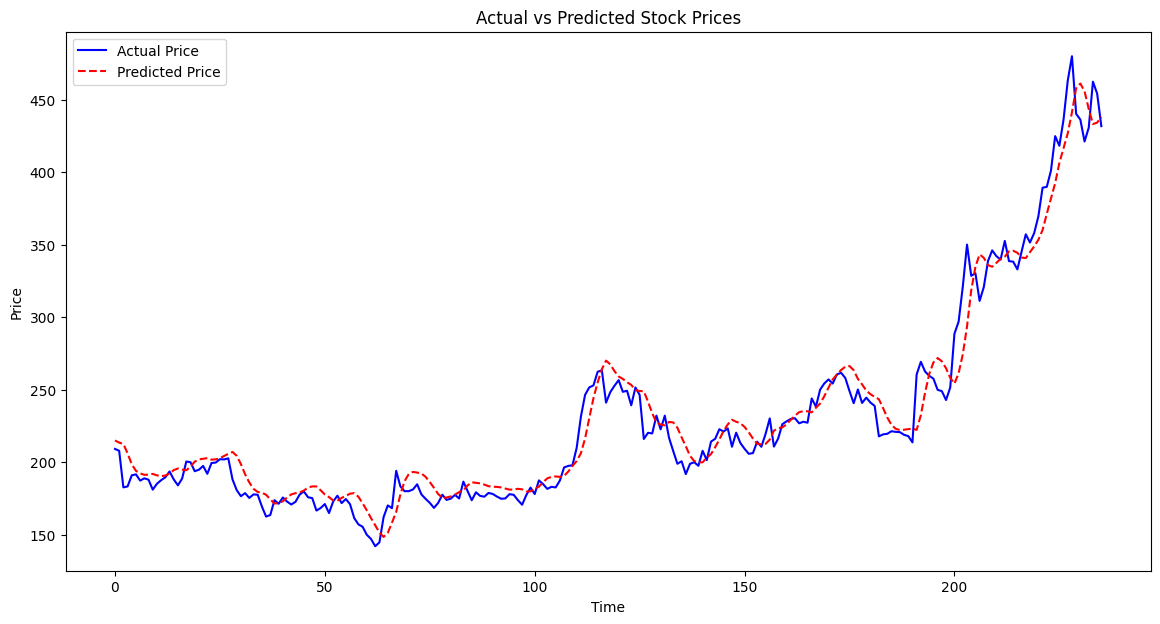

In [34]:
# Matplotlib 라이브러리를 가져옵니다.
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리

# 실제 데이터와 예측 데이터 비교 및 시각화 함수 정의
def plot_actual_vs_predicted(y_test, y_pred):
    # 그래프의 크기를 설정합니다.
    plt.figure(figsize=(14, 7))  # 가로 14인치, 세로 7인치 크기의 그래프 생성

    # 실제 값과 예측 값 비교
    plt.plot(y_test, label="Actual Price", color='blue')  # 실제 가격을 파란색 선으로 그립니다.
    plt.plot(y_pred, label="Predicted Price", color='red', linestyle='--')  # 예측 가격을 빨간색 점선으로 그립니다.

    # 그래프 제목과 축 레이블 설정
    plt.title('Actual vs Predicted Stock Prices')  # 그래프 제목 설정
    plt.xlabel('Time')  # x축 레이블: 시간 (또는 날짜)
    plt.ylabel('Price')  # y축 레이블: 가격
    plt.legend()  # 범례 추가 (각 선의 설명을 표시)

    # 그래프를 화면에 표시합니다.
    plt.show()  # 생성한 그래프를 화면에 출력

# 시각화 실행: 실제 가격과 예측 가격을 비교하여 시각화합니다.
plot_actual_vs_predicted(y_test, y_pred)

# PART-3 매수 매도 시뮬레이션

### 매수/매도 시뮬레이션 함수 정의

In [35]:
# 필요한 라이브러리 가져오기
import numpy as np  # 수치 계산을 위한 라이브러리
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리

def simulate_trading(data, y_test, y_pred, buy_threshold=-0.1, sell_threshold=0.1):
    # y_test가 NumPy 배열일 경우, Series로 변환
    if isinstance(y_test, np.ndarray):  # TensorFlow 예측값이 NumPy 배열일 경우
        y_test = pd.Series(y_test.flatten(), index=data.index[-len(y_test):])

    # y_pred가 NumPy 배열일 경우, Series로 변환
    if isinstance(y_pred, np.ndarray):  # TensorFlow 예측값이 NumPy 배열일 경우
        y_pred = pd.Series(y_pred.flatten(), index=y_test.index)

    # 예측된 주가를 데이터프레임에 추가
    data['Predicted'] = np.nan  # 'Predicted' 열 초기화 (NaN 값으로)
    data.loc[y_test.index, 'Predicted'] = y_pred  # 예측된 주가를 해당 인덱스에 추가

    # 신호 열 초기화
    data['Signal_Actual'] = 0  # 실제 주가 기반 매수/매도 신호
    data['Signal_Predicted'] = 0  # 예측 주가 기반 매수/매도 신호

    # 초기 매수 가격 및 포지션 설정
    initial_buy_price_actual = None  # 실제 주가 기준 최초 매수 가격 (초기값은 None)
    initial_buy_price_predicted = y_pred[0]  # 예측 주가 시작점에서 최초 매수 가격
    position_open_actual = False  # 실제 주가 포지션 여부 (초기값은 False)
    position_open_predicted = True  # 예측 주가 포지션은 최초 매수 후 열림 (True로 설정)

    # 매수 시점은 예측 구간의 첫 번째 시점으로 설정
    data.loc[y_test.index[0], 'Signal_Predicted'] = 1  # 첫 매수 신호

    # 매수/매도 신호 발생 (실제 주가 및 예측 주가 기준)
    for i in range(1, len(y_test)):  # y_test의 두 번째 인덱스부터 마지막까지 반복
        # 실제 및 예측 주가의 변화율 계산
        actual_price_change = (y_test.iloc[i] - y_test.iloc[i-1]) / y_test.iloc[i-1]  # 실제 주가 변화율
        predicted_price_change = (y_pred[i] - y_pred[i-1]) / y_pred[i-1]  # 예측 주가 변화율

        # ---------------------
        # 실제 주가 기준 매수/매도 신호
        # ---------------------
        # 실제 주가 최초 매수 신호: 가격 하락 시
        if not position_open_actual and actual_price_change <= buy_threshold:  # 포지션이 열려 있지 않고 매수 임계값 이하일 경우
            initial_buy_price_actual = y_test.iloc[i]  # 최초 매수 가격 기록
            data.loc[y_test.index[i], 'Signal_Actual'] = 1  # 매수 신호
            position_open_actual = True  # 포지션 열림 (매수됨)

        # 실제 주가 기준 매도 신호: 매수 후 10% 상승 시
        elif position_open_actual and (y_test.iloc[i] / initial_buy_price_actual - 1) >= sell_threshold:  # 포지션이 열려 있고 매도 임계값 이상일 경우
            data.loc[y_test.index[i], 'Signal_Actual'] = -1  # 매도 신호
            position_open_actual = False  # 포지션 닫음 (매도됨)

        # 실제 주가 기준 추가 매수 신호: 매수 후 10% 하락 시
        elif position_open_actual and (y_test.iloc[i] / initial_buy_price_actual - 1) <= buy_threshold:  # 포지션이 열려 있고 매수 임계값 이하일 경우
            data.loc[y_test.index[i], 'Signal_Actual'] = 1  # 추가 매수 신호

        # ---------------------
        # 예측 주가 기준 매수/매도 신호
        # ---------------------
        # 예측 주가 기준 매도 신호: 매수 후 10% 상승 시
        if position_open_predicted and (y_pred[i] / initial_buy_price_predicted - 1) >= sell_threshold:  # 포지션이 열려 있고 매도 임계값 이상일 경우
            data.loc[y_test.index[i], 'Signal_Predicted'] = -1  # 매도 신호
            position_open_predicted = False  # 포지션 닫음 (매도됨)

        # 예측 주가 기준 추가 매수 신호: 매수 후 10% 하락 시
        elif position_open_predicted and (y_pred[i] / initial_buy_price_predicted - 1) <= buy_threshold:  # 포지션이 열려 있고 매수 임계값 이하일 경우
            data.loc[y_test.index[i], 'Signal_Predicted'] = 1  # 추가 매수 신호

    return data  # 매수/매도 신호가 포함된 데이터프레임 반환


### 매수/매도 시뮬레이션 실행

In [36]:
# 시뮬레이션 실행
data = simulate_trading(data, y_test, y_pred)  # 이전에 정의한 simulate_trading() 함수를 호출하여 매수/매도 신호를 추가한 데이터를 생성

# 매수/매도 기록 저장
trades_actual = data[data['Signal_Actual'] != 0][['Close', 'Signal_Actual']]  # 실제 주가 기반 매수/매도 신호가 있는 행을 필터링하여 'Close'와 'Signal_Actual' 열만 선택
trades_predicted = data[data['Signal_Predicted'] != 0][['Close', 'Signal_Predicted']]  # 예측 주가 기반 매수/매도 신호가 있는 행을 필터링하여 'Close'와 'Signal_Predicted' 열만 선택

# 매매 기록 출력
print("Actual Price-based Trades:")  # 실제 주가 기반 매매 기록 제목 출력
print(trades_actual)  # 실제 주가 기반 매매 기록 출력

print("\nPredicted Price-based Trades:")  # 예측 주가 기반 매매 기록 제목 출력
print(trades_predicted)  # 예측 주가 기반 매매 기록 출력


Actual Price-based Trades:
                 Close  Signal_Actual
Date                                 
2024-01-25  182.630005              1
2024-02-28  202.039993             -1
2024-07-24  215.990005              1
2024-08-07  191.759995              1
2024-09-19  243.919998             -1

Predicted Price-based Trades:
                 Close  Signal_Predicted
Date                                    
2024-01-23  209.139999                 1
2024-01-31  187.289993                 1
2024-02-01  188.860001                 1
2024-02-02  187.910004                 1
2024-02-05  181.059998                 1
...                ...               ...
2024-06-21  183.009995                 1
2024-06-24  182.580002                 1
2024-06-25  187.350006                 1
2024-06-26  196.369995                 1
2024-07-08  252.940002                -1

[87 rows x 2 columns]


<ipython-input-35-60f78e74e59a>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_buy_price_predicted = y_pred[0]  # 예측 주가 시작점에서 최초 매수 가격
<ipython-input-35-60f78e74e59a>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_price_change = (y_pred[i] - y_pred[i-1]) / y_pred[i-1]  # 예측 주가 변화율
<ipython-input-35-60f78e74e59a>:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if position_open_predicted and (y_pred[i] / init

### 포트폴리오 시뮬레이션 (실제 및 예측 주가 기반)

In [37]:
def portfolio_simulation(data, signal_column):
    capital = 10000  # 초기 자본 ($10,000)
    num_stocks = 0  # 보유 주식 수
    portfolio_value = []  # 포트폴리오 가치 저장 리스트

    # 데이터 인덱스를 통해 각 날짜에 대해 반복
    for i in data.index:
        actual_price = data.loc[i, 'Close']  # 현재 날짜의 종가
        signal = data.loc[i, signal_column]  # 해당 날짜의 매수/매도 신호

        # 매수 신호가 발생했을 때
        if signal == 1 and capital > 0:  # 매수 신호가 1이고 자본이 남아있을 경우
            num_stocks_to_buy = capital // actual_price  # 구매할 수 있는 주식 수 계산
            if num_stocks_to_buy > 0:  # 구매할 수 있는 주식 수가 0보다 큰 경우
                capital -= num_stocks_to_buy * actual_price  # 자본에서 구매 금액 차감
                num_stocks += num_stocks_to_buy  # 보유 주식 수 증가

        # 매도 신호가 발생했을 때
        elif signal == -1 and num_stocks > 0:  # 매도 신호가 -1이고 보유 주식이 있는 경우
            capital += num_stocks * actual_price  # 자본에 보유 주식의 판매 금액 추가
            num_stocks = 0  # 주식 초기화 (모두 매도)

        # 포트폴리오 가치 업데이트
        portfolio_value.append(capital + num_stocks * actual_price)  # 현재 자본과 보유 주식의 가치를 합산하여 포트폴리오 가치에 추가

    return portfolio_value  # 최종 포트폴리오 가치 리스트 반환

# 실제 및 예측 주가 기반 포트폴리오 시뮬레이션 실행
portfolio_actual = portfolio_simulation(data, 'Signal_Actual')  # 실제 주가 기반 포트폴리오 시뮬레이션 실행
portfolio_predicted = portfolio_simulation(data, 'Signal_Predicted')  # 예측 주가 기반 포트폴리오 시뮬레이션 실행


### 시각화

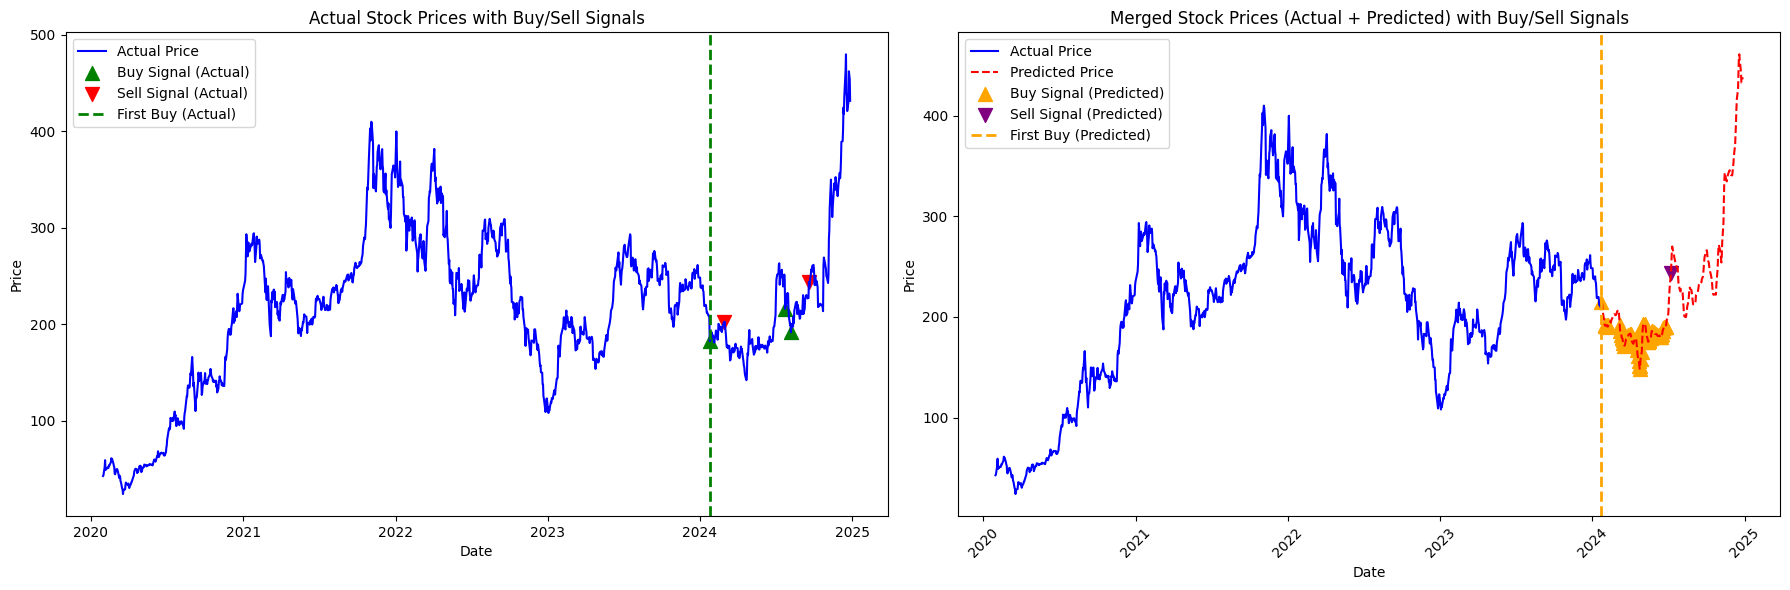

In [38]:
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리

# 예측 구간 동안의 실제 값을 삭제하고 예측 값으로 대체하는 함수
def merge_actual_and_predicted(data, y_test, y_pred):
    data['Merged'] = data['Close'].copy()  # 실제 주가를 'Merged' 열에 복사
    # y_test가 NumPy 배열일 경우, Series로 변환
    if isinstance(y_test, np.ndarray):  # TensorFlow 예측값이 NumPy 배열일 경우
        y_test = pd.Series(y_test.flatten(), index=data.index[-len(y_test):])

    # y_pred가 NumPy 배열일 경우, Series로 변환
    if isinstance(y_pred, np.ndarray):  # TensorFlow 예측값이 NumPy 배열일 경우
        y_pred = pd.Series(y_pred.flatten(), index=y_test.index)
    # 예측 구간에서 실제 주가를 삭제하고 예측 주가로 대체
    data.loc[y_test.index, 'Merged'] = y_pred  # y_test 인덱스에 해당하는 행을 예측 값으로 대체

    return data  # 변경된 데이터프레임 반환

# 데이터 병합 (예측 구간 대체)
data = merge_actual_and_predicted(data, y_test, y_pred)  # 실제 주가와 예측 주가 병합

# 시각화 함수 (1x2 레이아웃)
def plot_trading_simulation_1x2(data, y_test):

    # y_test가 NumPy 배열일 경우, Series로 변환
    if isinstance(y_test, np.ndarray):  # TensorFlow 예측값이 NumPy 배열일 경우
        y_test = pd.Series(y_test.flatten(), index=data.index[-len(y_test):])


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))  # 1x2 레이아웃 설정 (가로로 2개의 서브플롯)

    # 실제 주가 및 매수/매도 신호 시각화 (Actual)
    ax1.plot(data.index, data['Close'], label='Actual Price', color='blue')  # 실제 가격을 파란색 선으로 그립니다.

    # 실제 기반 매수/매도 신호 시각화
    buy_signals_actual = data[data['Signal_Actual'] == 1]  # 실제 매수 신호 데이터 필터링
    sell_signals_actual = data[data['Signal_Actual'] == -1]  # 실제 매도 신호 데이터 필터링

    ax1.scatter(buy_signals_actual.index, buy_signals_actual['Close'], marker='^', color='green', label='Buy Signal (Actual)', s=100)  # 매수 신호 표시
    ax1.scatter(sell_signals_actual.index, sell_signals_actual['Close'], marker='v', color='red', label='Sell Signal (Actual)', s=100)  # 매도 신호 표시

    # 초기 매수 시점에 대해 vline 추가 (녹색 수직선)
    if len(buy_signals_actual) > 0:
        first_buy_signal_actual = buy_signals_actual.index[0]  # 최초 매수 시점
        ax1.axvline(x=first_buy_signal_actual, color='green', linestyle='--', linewidth=2, label='First Buy (Actual)')  # 수직선 추가

    ax1.set_title('Actual Stock Prices with Buy/Sell Signals')  # 제목 설정
    ax1.set_xlabel('Date')  # x축 레이블 설정
    ax1.set_ylabel('Price')  # y축 레이블 설정
    ax1.legend()  # 범례 추가

    # 예측 구간의 첫 번째 인덱스
    first_predicted_idx = y_test.index[0]  # 예측 구간의 첫 번째 인덱스 가져옴

    # 실제 구간(예측 이전 구간)과 예측 구간을 나눠서 그리기
    # 예측 구간 이전 실제 구간은 파란색 실선으로
    ax2.plot(data.loc[:first_predicted_idx].index, data['Close'][:first_predicted_idx], label='Actual Price', color='blue')  # 실제 가격

    # 예측 구간은 빨간색 점선으로
    ax2.plot(data.loc[first_predicted_idx:].index, data['Merged'][first_predicted_idx:], label='Predicted Price', color='red', linestyle='--')  # 예측 가격

    # 예측 기반 매수/매도 신호 시각화
    buy_signals_predicted = data[data['Signal_Predicted'] == 1]  # 예측 매수 신호 데이터 필터링
    sell_signals_predicted = data[data['Signal_Predicted'] == -1]  # 예측 매도 신호 데이터 필터링

    ax2.scatter(buy_signals_predicted.index, buy_signals_predicted['Merged'], marker='^', color='orange', label='Buy Signal (Predicted)', s=100)  # 매수 신호 표시
    ax2.scatter(sell_signals_predicted.index, sell_signals_predicted['Merged'], marker='v', color='purple', label='Sell Signal (Predicted)', s=100)  # 매도 신호 표시

    # 예측 구간에서 초기 매수 시점에 대해 vline 추가 (주황색 수직선)
    if len(buy_signals_predicted) > 0:
        first_buy_signal_predicted = buy_signals_predicted.index[0]  # 최초 매수 시점
        ax2.axvline(x=first_buy_signal_predicted, color='orange', linestyle='--', linewidth=2, label='First Buy (Predicted)')  # 수직선 추가

    ax2.set_title('Merged Stock Prices (Actual + Predicted) with Buy/Sell Signals')  # 제목 설정
    ax2.set_xlabel('Date')  # x축 레이블 설정
    ax2.set_ylabel('Price')  # y축 레이블 설정
    ax2.legend()  # 범례 추가

    # 레이아웃 조정 및 출력
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.tight_layout()  # 레이아웃 조정
    plt.show()  # 그래프 표시

# 시각화 실행 (1x2 레이아웃)
plot_trading_simulation_1x2(data, y_test)  # 함수 호출하여 시각화 실행
